In [4]:
import os
import sys

cur_dir = os.getcwd()
CHECKPOINT_DIR = os.path.join(cur_dir, "checkpoints")
sys.path.append(os.path.join(cur_dir, "lsh_lib"))
sys.path.append(os.path.join(cur_dir, "mongoose_slide"))

print(CHECKPOINT_DIR)

/home2/vanshg/mongoose/checkpoints


In [ ]:
from src.lsh_layer import LSHLayer

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [15]:
from clsh import pyLSH
from mongoose_slide.slide_lib.lsh import LSH
# from mongoose_slide.slide_lib.simHash import SimHash
from mongoose_slide.slide_lib.projectionHash import RandomProjection

from src.models.simple_mlp import SimpleMLP
from src.models.two_layer_lsh import TwoLayerLSH
from src.utils import eval

In [5]:
from mnist_lsh import LSHLayer, MNISTNET

In [6]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Loading MNIST DATA


In [8]:
# Define transformations and download the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"size of train_dataset: {len(train_dataset)}")
print(f"size of test dataset: {len(test_dataset)}")

size of train_dataset: 60000
size of test dataset: 10000


## Normal MLP on MNIST

In [18]:
model_path = os.path.join(CHECKPOINT_DIR, "mnist_h10000.pt")

model_state_dict = torch.load(model_path)

num_epochs = 20
hidden_size = 10000
num_classes = 10
model = SimpleMLP(28 * 28, hidden_size, num_classes, flatten_first=True)

model.load_state_dict(model_state_dict)

model.to(device)
model.eval()

SimpleMLP(
  (hidden_fc): Linear(in_features=784, out_features=10000, bias=True)
  (output_fc): Linear(in_features=10000, out_features=10, bias=True)
)

### Average Inference Time

In [20]:
total_time = 0
num_examples = 0

model.eval()
with torch.no_grad():
    for x, y in train_dataset:
        x = x.to(device)
        # y = y.to(device)
        st_time = time.time()
        out = model(x)
        time_taken = time.time() - st_time
        
        total_time += time_taken
        num_examples += 1

avg_inference_time = total_time/num_examples
print(f"Total Time: {total_time} | Number of Examples: {num_examples}")
print(f"Average Inference Time: {avg_inference_time}")

Total Time: 6.530989170074463 | Number of Examples: 60000
Average Inference Time: 0.00010884981950124105


## LSH MLP on MNIST

In [21]:
model_path = os.path.join(CHECKPOINT_DIR, "mnist_lsh_h10000.pt")

model_state_dict = torch.load(model_path)

num_epochs = 20
hidden_size = 10000
num_classes = 10
K = 14
L = 50
threads = 1
model = TwoLayerLSH(28 * 28, hidden_size, num_classes, K, L, threads, flatten_first=True)

model = model.to(device)
model.eval()

cuda:0
cuda:0


TwoLayerLSH(
  (hidden_fc): LSHLayer(
    (params): Linear(in_features=784, out_features=10000, bias=True)
  )
  (output_fc): Linear(in_features=10000, out_features=10, bias=True)
)

In [22]:
total_time = 0
num_examples = 0

model.eval()
with torch.no_grad():
    for x, y in train_dataset:
        x = x.to(device)
        # y = y.to(device)
        st_time = time.time()
        out = model(x)
        time_taken = time.time() - st_time
        
        total_time += time_taken
        num_examples += 1

avg_inference_time = total_time/num_examples
print(f"total time: {total_time} | number of examples: {num_examples}")
print(f"average inference time: {avg_inference_time}")

Total Time: 42.08781814575195 | Number of Examples: 60000
Average Inference Time: 0.0007014636357625325


In [40]:
input_size = 28 * 28
hidden_size = 10000
num_classes = 10
K = 14
L = 50
threads = 1
model = MNISTNET(input_size, hidden_size, num_classes, K, L, threads=threads)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

cuda:0
cuda:0


In [13]:
def eval(model, eval_loader, criterion):
    total_loss = 0.0
    num_correct = 0
    total_eval = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_eval += labels.size(0)
            num_correct += (predicted == labels).sum().item()
    
        avg_loss = total_loss/len(eval_loader)
        eval_acc = num_correct/total_eval
    
    return avg_loss, eval_acc

In [41]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_iters = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_iters += 1
    
    model.rebuild_lsh()

    train_loss, train_acc = eval(model, train_loader, criterion)
    test_loss, test_acc = eval(model, test_loader, criterion)
    # Print the training loss and accuracy after each epoch
    print(f"Average activations: {model.hidden_fc.avg_activ}")
    print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}% ' +
          f'| Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}')

print(f"Total Train iters: {train_iters}")

Average activations: 1246.2132196162047
Epoch [1/20] | Train Loss: 7.2957 | Train Acc: 82.32% | Test Loss: 7.1114 | Test Acc: 82.07
Average activations: 1221.7142857142858
Epoch [2/20] | Train Loss: 5.0333 | Train Acc: 84.98% | Test Loss: 4.8236 | Test Acc: 85.34
Average activations: 1209.1229566453446
Epoch [3/20] | Train Loss: 3.5845 | Train Acc: 87.11% | Test Loss: 3.4218 | Test Acc: 87.23
Average activations: 1200.306236673774
Epoch [4/20] | Train Loss: 2.8072 | Train Acc: 88.36% | Test Loss: 2.8304 | Test Acc: 88.09
Average activations: 1194.0119402985074
Epoch [5/20] | Train Loss: 2.2715 | Train Acc: 88.96% | Test Loss: 2.2434 | Test Acc: 88.85
Average activations: 1188.8816631130064
Epoch [6/20] | Train Loss: 1.9107 | Train Acc: 90.07% | Test Loss: 1.9446 | Test Acc: 90.03
Average activations: 1183.9996954005483
Epoch [7/20] | Train Loss: 1.6359 | Train Acc: 90.77% | Test Loss: 1.7715 | Test Acc: 90.20
Average activations: 1180.2595948827293
Epoch [8/20] | Train Loss: 1.5116 | T

In [42]:
print(model.hidden_fc.train_iters)
print(model.train_iters)

18760
18760


In [49]:
count = (freqs == freqs.max()).sum()
count0 = (freqs == 0).sum()
print(count0)
print(count)

137
2


Total training iterations: 0
Min: 0.0, Max: 0.0, Mean: 0.0


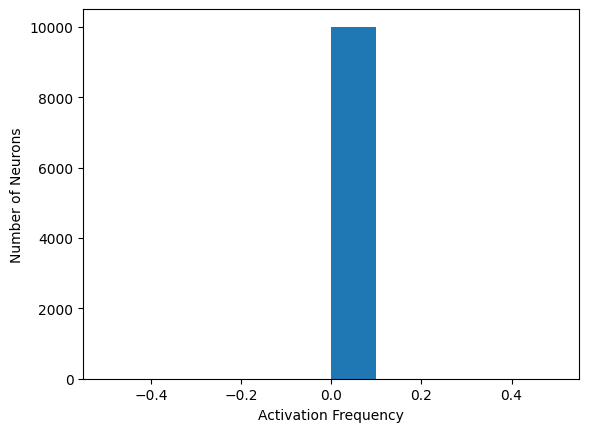

In [23]:
freqs = model.hidden_fc.activ_freq
print(f"Total training iterations: {model.train_iters}")
print(f"Min: {freqs.min()}, Max: {freqs.max()}, Mean: {freqs.mean()}")
plt.hist(freqs)

plt.xlabel("Activation Frequency")
plt.ylabel("Number of Neurons")

plt.show()

Text(0, 0.5, 'Activation frequency')

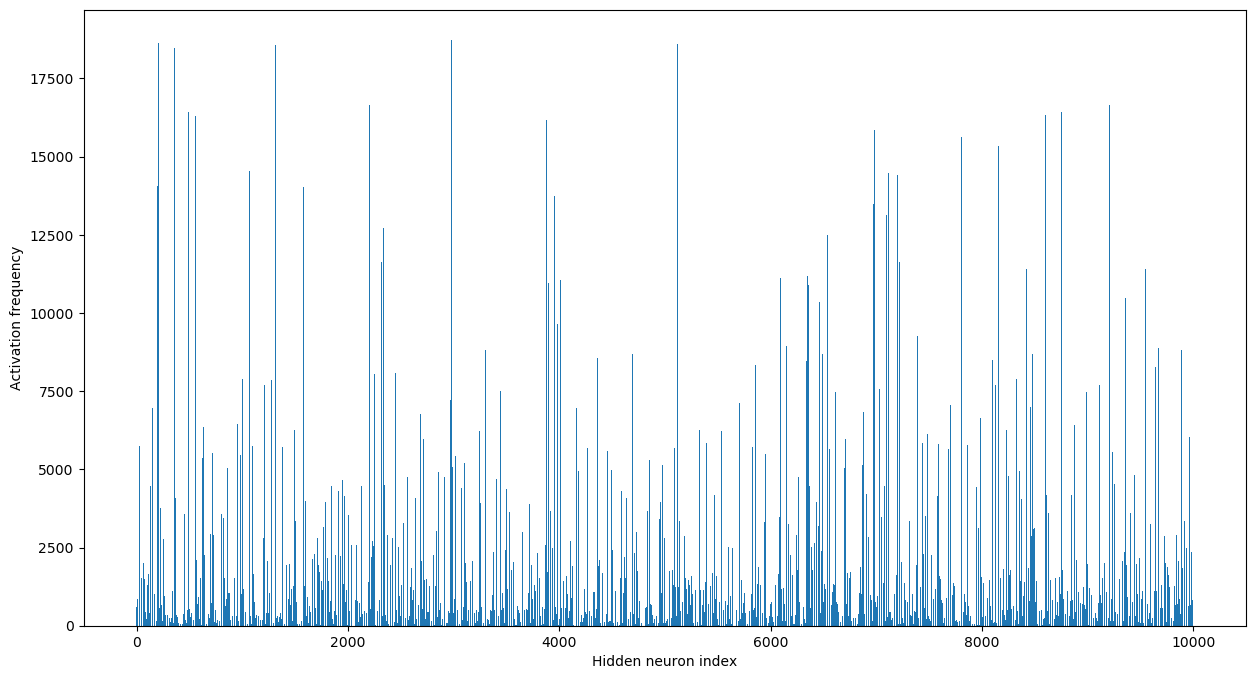

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.bar(np.arange(hidden_size), model.hidden_fc.activ_freq)

plt.xlabel("Hidden neuron index")
plt.ylabel("Activation frequency")

### how many each neuron is activated for each class


In [54]:
print((hidden_size, num_classes))
# print(model.hidden_fc..shape)

(10000, 10)


In [51]:
neuron_class_freq = np.zeros((hidden_size, num_classes))

model.eval()
with torch.no_grad():
    for x, y in train_dataset:
        x = x.to(device)
        out = model(x)
        neuron_ids = model.hidden_fc.last_neurons
        neuron_class_freq[neuron_ids, y] += 1

In [74]:
print(np.max(neuron_class_freq[:, 1]))

3916.0


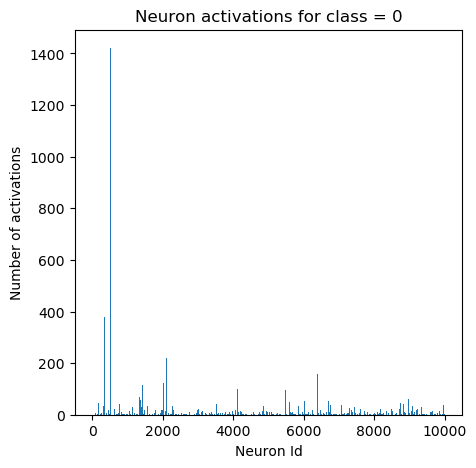

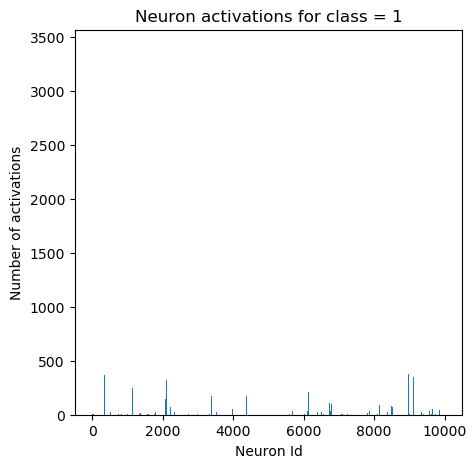

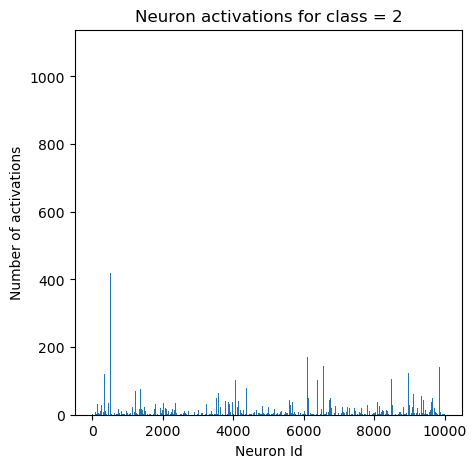

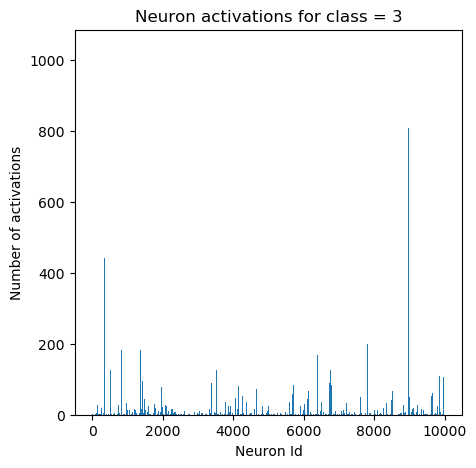

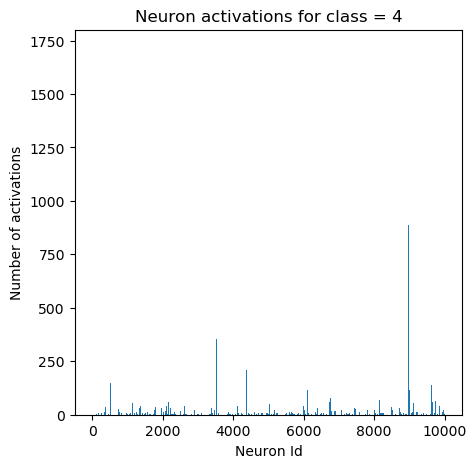

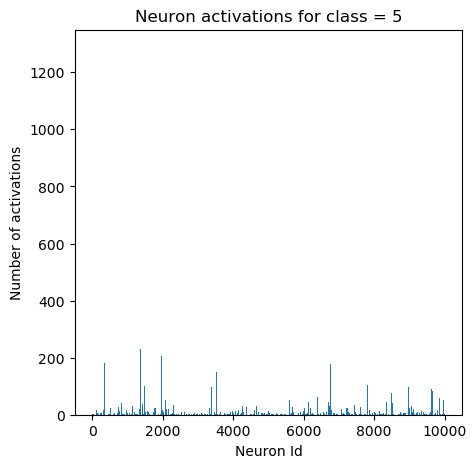

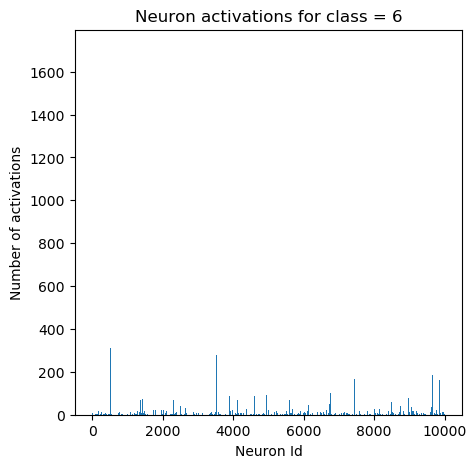

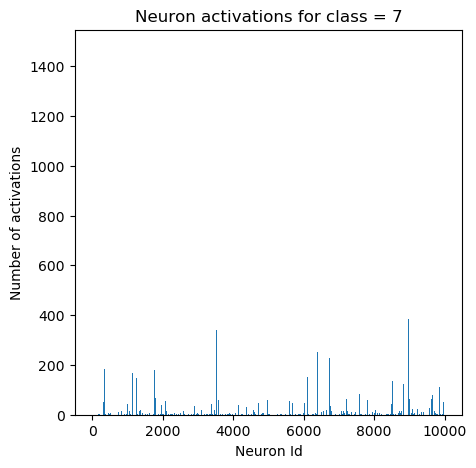

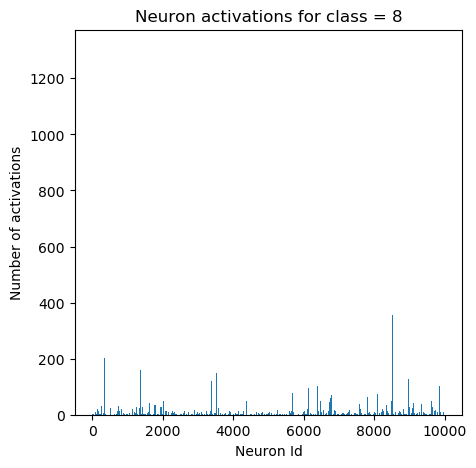

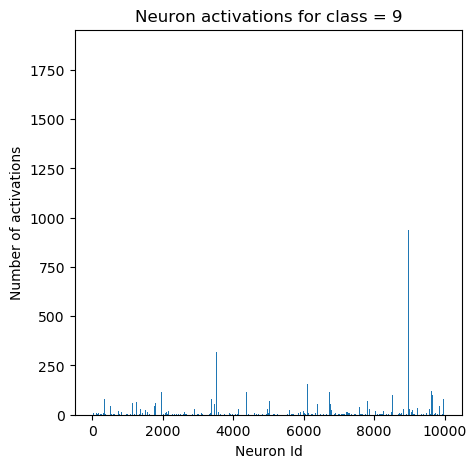

In [45]:
for i in range(num_classes):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.bar(np.arange(hidden_size), neuron_class_freq[:, i])
    ax.set_title(f"Neuron activations for class = {i}")
    ax.set_xlabel("Neuron Id")
    ax.set_ylabel("Number of activations")
    plt.show()

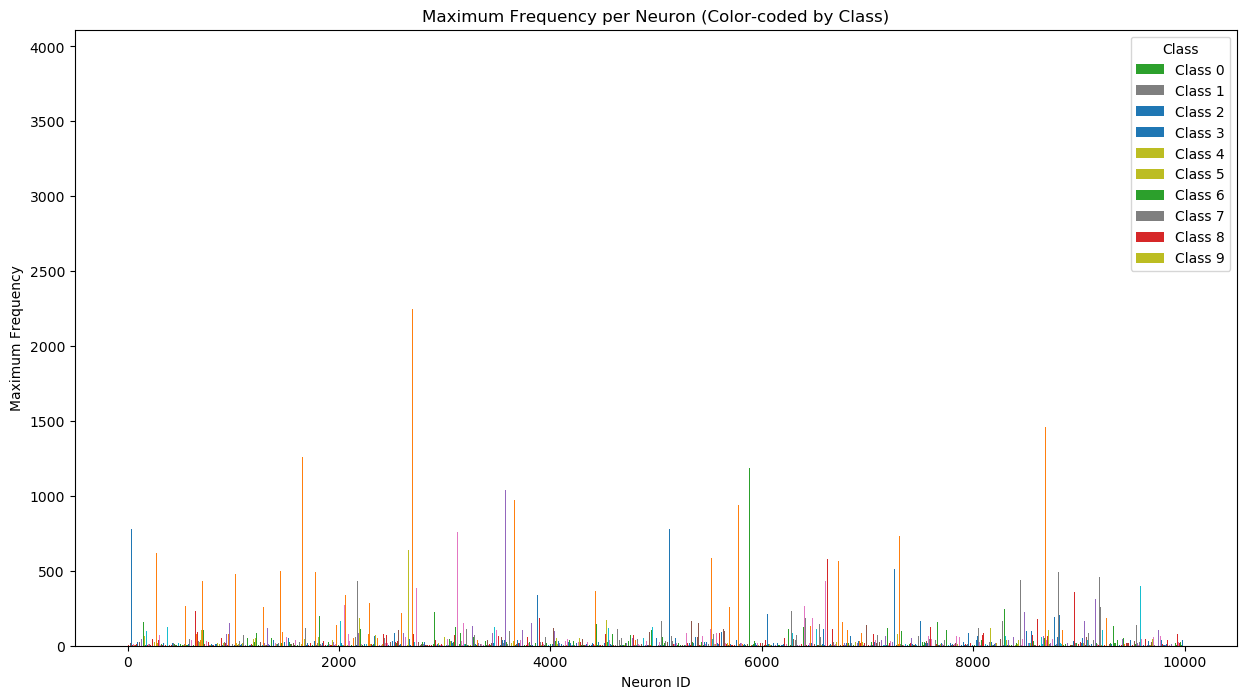

In [75]:
# Find the class with the maximum frequency for each neuron
num_neurons = hidden_size
freq_array = neuron_class_freq
max_class_per_neuron = np.argmax(freq_array, axis=1)

# Find the maximum frequency for each neuron
max_freq_per_neuron = np.max(freq_array, axis=1)

# Create a color map for class coloring
color_map = plt.get_cmap('tab10')

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(range(num_neurons), max_freq_per_neuron, color=color_map(max_class_per_neuron), linewidth=2)

# Set labels and title
ax.set_xlabel('Neuron ID')
ax.set_ylabel('Maximum Frequency')
ax.set_title('Maximum Frequency per Neuron (Color-coded by Class)')

# Create a legend
legend_labels = [f'Class {i}' for i in range(num_classes)]
ax.legend(bars, legend_labels, title='Class', loc='upper right')

plt.show()

In [67]:
classes, counts = np.unique(max_class_per_neuron, return_counts=True)
print(counts)

[1674  541 1643 1125  803  689 1087  929  921  588]


In [76]:
classes, counts = np.unique(max_class_per_neuron, return_counts=True)
print(counts)

[1851  472 1616 1172  861  645 1081  904  868  530]


In [77]:
freqs = np.zeros(num_classes)
for x, y in train_dataset:
    freqs[y] += 1

print(freqs)

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]


## Testing with LSH


In [26]:
N = 500
D = 10
K = 320
L = 50
hash_func = SimHash(D, K, L)
lsh = LSH(hash_func, K, L, threads_=1)

data = torch.randn((N, D))

res = lsh.insert_multi(data, N)

random generate hash table weight


In [154]:
lsh.insert(N, data[0].reshape(1, -1))

data.shape: torch.Size([1, 784])


In [139]:
data[0].reshape(1, -1).shape

torch.Size([1, 784])

In [27]:
for i in range(N):
    point = data[i].reshape(1, -1)
    sid = lsh.query(point)
    if len(sid) > 1:
        print(f"{i}: length = {len(sid)}, {sid}")

1: length = 2, {1, 238}
4: length = 2, {276, 4}
31: length = 2, {186, 31}
33: length = 2, {33, 309}
34: length = 2, {34, 101}
41: length = 2, {80, 41}
43: length = 2, {43, 61}
49: length = 3, {145, 293, 49}
54: length = 2, {245, 54}
58: length = 2, {58, 94}
61: length = 2, {43, 61}
62: length = 2, {378, 62}
79: length = 2, {79, 439}
80: length = 2, {80, 41}
87: length = 2, {202, 87}
91: length = 2, {202, 91}
94: length = 2, {58, 94}
101: length = 2, {34, 101}
111: length = 2, {373, 111}
112: length = 2, {208, 112}
119: length = 3, {274, 228, 119}
124: length = 3, {219, 124, 127}
127: length = 2, {124, 127}
129: length = 2, {401, 129}
132: length = 2, {490, 132}
140: length = 2, {140, 485}
142: length = 2, {285, 142}
145: length = 2, {49, 145}
146: length = 2, {258, 146}
165: length = 2, {193, 165}
166: length = 2, {372, 166}
175: length = 2, {356, 175}
180: length = 2, {497, 180}
186: length = 2, {186, 31}
193: length = 2, {193, 165}
199: length = 2, {229, 199}
202: length = 3, {202, 9

In [29]:
print(data[1])
print(data[238])

tensor([ 0.0495,  1.1381, -0.6637, -0.4138,  0.3307,  1.8156, -0.6727, -0.3608,
         0.0823, -0.7224])
tensor([-0.0809,  0.7682, -0.1386,  0.1480,  0.8763,  0.8390, -0.7241, -0.2870,
        -0.7389,  0.1615])


In [28]:
point = data[1].reshape(1, -1)
print(point.shape)
sid = lsh.query(point)
print(sid)
# sid, hashcode = lsh.query(point)

torch.Size([1, 10])
{1, 238}


In [62]:
hashcodes = hash_func.hash(data).int().cpu().numpy()
print(hashcodes.shape)

print(np.unique(hashcodes[0]).shape)

print(np.unique(hashcodes[1]).shape)

(500, 50)
(50,)
(50,)


In [63]:
print(hashcodes)

[[ 2023405622  -835523120 -1506438146 ...  1912466404  1996453664
  -1674322994]
 [-2014976343  1368030539   500123074 ...   768223197   126082721
   -607360976]
 [-1108936786 -1048090909 -1437104598 ...   629359579  1744248740
  -1219663554]
 ...
 [-1666225160   845766761  1760488851 ...   365270129    29839675
     90446361]
 [ -793864923  1109812337 -1489532258 ... -2076071295  1996109734
  -1860269742]
 [-1552824943  -174083473   500780162 ...  1746021593 -2097103691
   1807771810]]


torch.Size([500, 10])


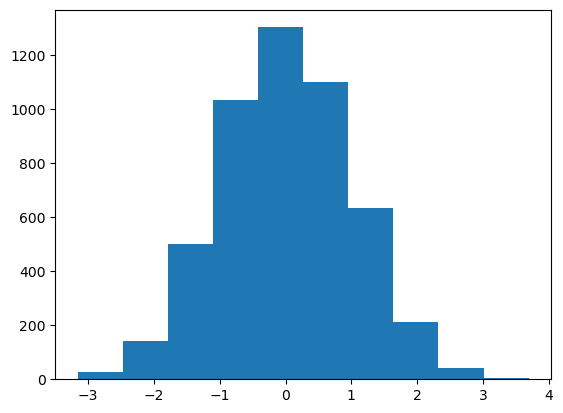

In [43]:
print(data.shape)
data_vals = data.cpu().numpy().flatten()
plt.hist(data_vals)
plt.show()

[-1.  1.]


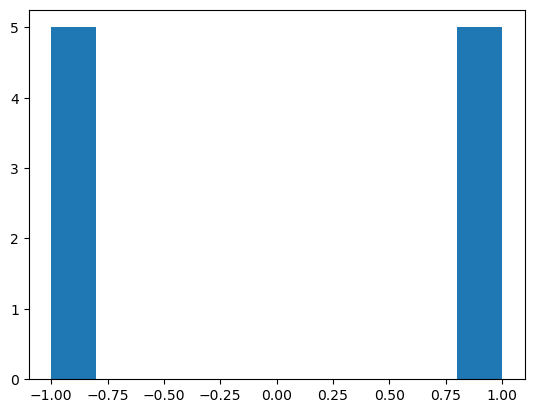

In [52]:
rp_vals = hash_func.rp[:, 8].cpu().numpy().flatten()
print(np.unique(rp_vals))
plt.hist(rp_vals)
plt.show()

In [55]:
data = data.to(device)
hashcodes = data @ hash_func.rp
print(hashcodes.shape)

torch.Size([500, 16000])


In [58]:
print(hashcodes.min(), hashcodes.max())

tensor(-14.0822, device='cuda:0') tensor(14.0822, device='cuda:0')


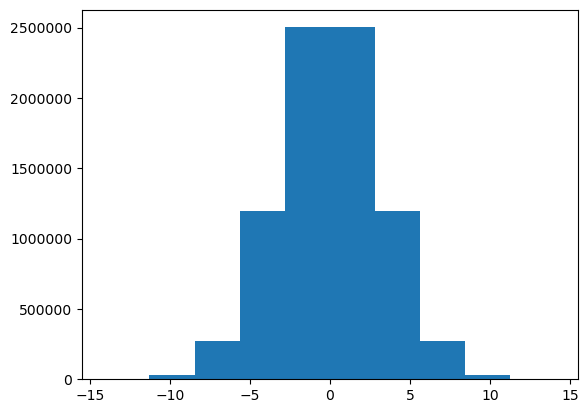

In [56]:
plt.hist(hashcodes.cpu().flatten().numpy())
plt.show()

In [60]:
fingering = hash_func.fingerprint(hashcodes, N)
print(fingering.shape)

torch.Size([500, 50])


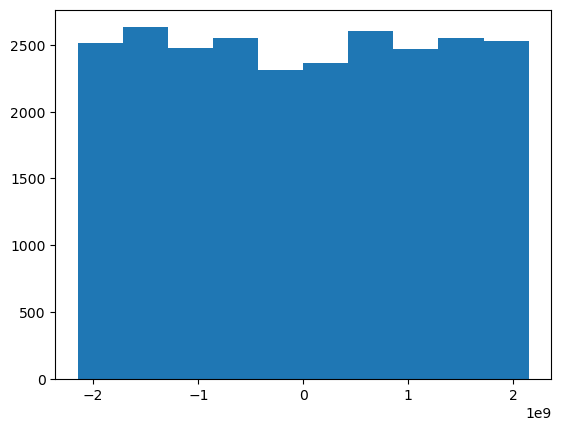

In [61]:
plt.hist(fingering.cpu().flatten().numpy())
plt.show()

## Testing Random Projection Hash


In [56]:
from math import log

print(log(10000, 2))

13.28771237954945


In [104]:
N = 10000
D = 784
K = 11
L = 2

hash_func = RandomProjection(D, K, L)
lsh = LSH(hash_func, K, L, threads_=1)

data = torch.randn((N, D))

res = lsh.insert_multi(data, N)

cuda:0


In [88]:
point = train_dataset[0][0].reshape(1, -1)
sid = lsh.query(point)
print(len(sid))
print(sid)
print(point.shape)

26
{3200, 8194, 2951, 6027, 911, 1813, 666, 9755, 1308, 4766, 1312, 2720, 6946, 2979, 9003, 9913, 5437, 7109, 1480, 2760, 1634, 7651, 4330, 2802, 248, 1913}
torch.Size([1, 784])


In [105]:
for i, (x, y) in enumerate(train_dataset):
    point = x.reshape(1, -1)
    sid = lsh.query(point)
    bucket = lsh.func.hash(point)
    print(f"{i}: length = {len(sid)}, bucket = {bucket[0, 0]} {sid}")

0: length = 7, bucket = 1638 {7722, 9870, 4431, 5681, 6708, 2453, 3642}
1: length = 11, bucket = 1078 {7202, 4963, 1890, 1860, 898, 5835, 6222, 9486, 3732, 5753, 5343}
2: length = 14, bucket = 1934 {2305, 3511, 292, 8421, 7687, 4009, 2922, 1869, 6733, 1715, 2935, 3448, 3513, 539}
3: length = 10, bucket = 1030 {3905, 4802, 5865, 5706, 555, 271, 947, 6134, 1880, 2907}
4: length = 22, bucket = 1126 {3458, 4742, 5897, 394, 6047, 3879, 9383, 4265, 6189, 3249, 4025, 5819, 5054, 7232, 1363, 9299, 5590, 5847, 8664, 7643, 8672, 3176}
5: length = 15, bucket = 1574 {9504, 8352, 6435, 6596, 8099, 8197, 4392, 9116, 8459, 8461, 4944, 6618, 7420, 3870, 9502}
6: length = 9, bucket = 1390 {9185, 5476, 6988, 1868, 6323, 8019, 185, 6170, 7996}
7: length = 13, bucket = 34 {4743, 841, 7722, 7690, 4431, 9135, 5681, 9523, 6708, 2260, 2453, 2267, 6494}
8: length = 13, bucket = 1094 {4321, 3779, 7332, 7397, 1125, 9256, 939, 5140, 8212, 4889, 9015, 5558, 1881}
9: length = 11, bucket = 1094 {2818, 9474, 7332, 11

In [ ]:
for i in range(N):
    point = data[i].reshape(1, -1)
    sid = lsh.query(point)
    if len(sid) > 1:
        print(f"{i}: length = {len(sid)}, {sid}")

In [48]:
result = hash_func.hash(data)
print(type(result))
print(result.shape)
print(result)

<class 'torch.Tensor'>
torch.Size([500, 50])
tensor([[0, 6, 2,  ..., 5, 4, 1],
        [1, 2, 0,  ..., 4, 6, 7],
        [5, 1, 2,  ..., 0, 6, 4],
        ...,
        [7, 6, 3,  ..., 2, 6, 7],
        [6, 7, 7,  ..., 5, 4, 4],
        [6, 2, 7,  ..., 1, 7, 1]], device='cuda:0', dtype=torch.int32)


In [50]:
print(result.min(), result.max())
print(result.unique())

tensor(0, device='cuda:0', dtype=torch.int32) tensor(7, device='cuda:0', dtype=torch.int32)
tensor([0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0', dtype=torch.int32)
